In [2]:
import cantera as ct
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt



In [3]:
# Unit conversions
psi2Pa = 6894.76

In [18]:
# setpoints of engine
OF = 2.1

#mass flow rates [kg/s]
mdot_total = 9 
mdot_lox = mdot_total * (OF/(OF+1))
mdot_kero = mdot_total * (1 / (OF + 1))

# Propellant Temps [K]
T_lox = 90 
T_kero = 2000
T_amb = 298

#pressures [Pa]
P_chamber = 500 * psi2Pa 
P_amb = 14.7 * psi2Pa

In [19]:
# kerosene molar ratio
X_kero = {"POSF10325": 1.0}

# lox molar ratio
X_lox = {"O2": 1.0}

In [20]:
# RP-1 reaction mechanism
kerosene = ct.Solution("A2NTC_skeletal.yaml")
kerosene.TPX = T_kero, P_chamber, X_kero

lox  = ct.Solution("A2NTC_skeletal.yaml")
lox.TPX = T_lox, P_chamber, X_lox

# arbitrary exhaust 
exhaust = ct.Solution("A2NTC_skeletal.yaml")
exhaust.TP = T_amb, P_amb


In [21]:
# lox & kero res --(mass flow controllers)-> mixer -> chamber --(Pressure Reg)-> outlet 

# reservoirs
res_lox = ct.Reservoir(lox, name="LOX Reservoir", clone=True)
res_kero= ct.Reservoir(kerosene, name="Kerosene Reservoir", clone=True)
outlet = ct.Reservoir(exhaust, name="Outlet", clone=True)

# reactors 
mixer = ct.IdealGasReactor(kerosene, name="Mixer", clone=True, energy='off')
chamber = ct.ConstPressureReactor(kerosene, name="Chamber", clone=True,  energy='on')

# mass flow controllers
mfc_lox = ct.MassFlowController(upstream= res_lox, downstream= mixer, mdot=mdot_lox, name="LOX Inlet") #lox res to mixer
mfc_kero = ct.MassFlowController(upstream= res_kero, downstream= mixer, mdot=mdot_kero,  name="Kerosene Inlet") #kero res to mixer
mixed_to_chamber = ct.MassFlowController(upstream=mixer, downstream=chamber, mdot=mdot_lox + mdot_kero, name="Mixer to Chamber")

#pressure controllers
pc_outlet = ct.PressureController(upstream=chamber, downstream=outlet, primary=mfc_lox, K=1e-5)

sim = ct.ReactorNet([mixer,chamber])

In [25]:
# Create a SolutionArray to store the data
time_history = ct.SolutionArray(exhaust, extra=["t"])

# Set the maximum simulation time
max_simulation_time = 50  # seconds

# Start the stopwatch
tic = time.time()

# Set simulation start time to zero
t = 0
counter = 1
while t < max_simulation_time:
    t = sim.step()

    # We will store only every 10th value.
    if counter % 10 == 0:
        # Extract the state of the reactor
        time_history.append(chamber.phase.state, t=t)

    counter += 1

# Stop the stopwatch
toc = time.time()

print(f"Simulation Took {toc-tic:3.2f}s to compute, with {counter} steps")

CanteraError: 
*******************************************************************************
CanteraError thrown by CVodesIntegrator::step:
CVodes error encountered. Error code: -3

cvHandleFailure: At t = 1.04307026637197 and h = 4.27623135933679e-10, the error test failed repeatedly or with |h| = hmin.
Components with largest weighted error estimates:
92: 20.579967432540354
85: 17.212340794561374
67: -16.732388853289333
80: 15.152927427914713
79: 10.459717633239542
89: -3.4177551168371876
75: -0.7904594434782408
65: -0.6630045229555173
84: -0.32118671957638634
58: 0.27867537864081804
*******************************************************************************


In [26]:
df = time_history.to_pandas()
df

,t,T,density,Y_POSF10325,Y_C2H4,Y_CH4,Y_C3H6,Y_iC4H8,Y_C4H81,Y_H2,...,Y_C6H5O,Y_C6H5CO,Y_C6H5CHO,Y_A2C11H21,Y_A2C11H21O2,Y_A2C11H20OOH,Y_A2C11H20,Y_A2C11H21O4,Y_A2C11H20O3,Y_N2
0,1.036413,1695.921666,5.036818,5.727016e-17,0.124612,0.197626,0.004672,0.000285,0.000349,0.023644,...,1.005632e-07,9.029462e-08,6.542819e-07,1.516030e-20,2.605027e-31,8.120945e-31,1.689128e-27,5.777128e-44,5.680193e-37,2.831854e-24
1,1.036413,1695.921796,5.036817,5.727028e-17,0.124612,0.197626,0.004672,0.000285,0.000349,0.023644,...,1.005632e-07,9.029472e-08,6.542822e-07,1.516035e-20,2.605036e-31,8.120973e-31,1.689132e-27,5.777152e-44,1.183010e-37,2.831856e-24
2,1.036414,1695.923411,5.036805,5.727189e-17,0.124611,0.197625,0.004672,0.000285,0.000349,0.023645,...,1.005634e-07,9.029588e-08,6.542860e-07,1.516099e-20,2.605150e-31,8.121327e-31,1.689183e-27,5.777457e-44,1.179377e-37,2.831886e-24
3,1.036420,1695.941206,5.036668,5.728969e-17,0.124603,0.197618,0.004671,0.000285,0.000349,0.023647,...,1.005654e-07,9.030862e-08,6.543279e-07,1.516798e-20,2.606407e-31,8.125223e-31,1.689754e-27,5.780813e-44,1.179883e-37,2.832216e-24
4,1.036475,1696.111205,5.035361,5.746024e-17,0.124521,0.197551,0.004664,0.000284,0.000349,0.023665,...,1.005848e-07,9.043033e-08,6.547278e-07,1.523505e-20,2.618458e-31,8.162575e-31,1.695223e-27,5.813008e-44,1.184742e-37,2.835371e-24
5,1.036795,1697.109580,5.027692,5.848257e-17,0.124046,0.197153,0.004626,0.000280,0.000344,0.023776,...,1.006976e-07,9.114719e-08,6.570726e-07,1.563757e-20,2.690820e-31,8.386850e-31,1.728000e-27,6.006855e-44,1.213889e-37,2.853892e-24
6,1.036888,1697.405468,5.025423,5.879250e-17,0.123905,0.197035,0.004614,0.000279,0.000343,0.023809,...,1.007308e-07,9.136032e-08,6.577663e-07,1.575980e-20,2.712802e-31,8.454971e-31,1.737936e-27,6.065916e-44,1.222733e-37,2.859380e-24
7,1.037128,1698.173864,5.019536,5.961262e-17,0.123540,0.196728,0.004584,0.000276,0.000340,0.023894,...,1.008162e-07,9.191526e-08,6.595648e-07,1.608363e-20,2.771068e-31,8.635520e-31,1.764227e-27,6.222855e-44,1.246154e-37,2.873628e-24
8,1.037718,1700.122973,5.004650,6.179614e-17,0.122615,0.195946,0.004510,0.000269,0.000332,0.024111,...,1.010285e-07,9.333226e-08,6.641084e-07,1.694883e-20,2.926890e-31,9.118261e-31,1.834219e-27,6.645301e-44,1.308640e-37,2.909754e-24
9,1.038829,1704.057622,4.974806,6.670073e-17,0.120758,0.194358,0.004363,0.000256,0.000316,0.024549,...,1.014380e-07,9.623356e-08,6.731968e-07,1.890801e-20,3.280533e-31,1.021329e-30,1.991433e-27,7.618228e-44,1.449702e-37,2.982559e-24


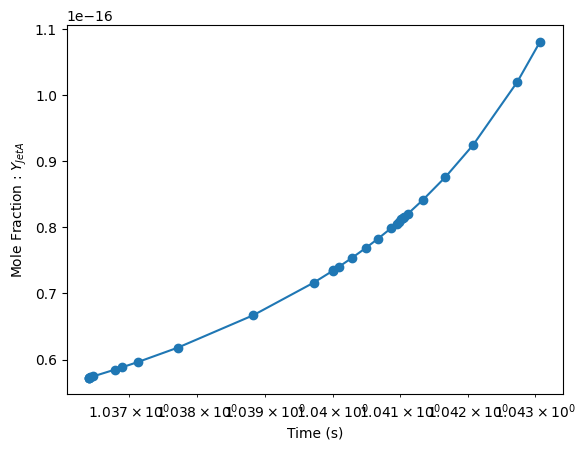

In [27]:
plt.figure()
plt.semilogx(time_history.t, time_history.POSF10325, "-o")
plt.xlabel("Time (s)")
plt.ylabel("Mole Fraction : $Y_{Jet A}$")
plt.show()